In [1]:
from __future__ import print_function
from __future__ import division

import pdb
import sys
import os
import yaml

import numpy as np
import scipy.optimize as opt
from scipy import interpolate
import scipy.io as sio
import scipy.special as spf

## import diffrantion integral solver from Optics folder
project_path = ('/Users/chair/Documents/Academia/SuperRes/Biteen_colab/'
    +
    'Mispolarization/python/gitted'
    )
optics_path = project_path + '/Optics'
sys.path.append(optics_path)
# sys.path.append(date_dir)
import diffraction_int as diffi
import fibonacci as fib

## Read parameter file to obtain physical properties 
## of molecule and plasmon, molecule and imaging system.
parameter_files_path = (
    project_path + '/parameter_files'
)

curly_yaml_file_name = '/curly_nrod_water_JC.yaml'
parameters = yaml.load(open(parameter_files_path+curly_yaml_file_name,'r'))


modules_path = project_path + '/solving_problems/modules'
sys.path.append(modules_path)

import fitting_misLocalization as fit

## plotting stuff
import matplotlib.pyplot as plt
import matplotlib as mpl
get_ipython().magic('matplotlib inline')
# mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
mpl.rcParams['text.usetex'] = True

## colorbar stuff 
from mpl_toolkits import axes_grid1

## Import analytic expressions for the focused fields from a point dipole.
import anal_foc_diff_fields as afi

## Import computational solution to two coupled oscillators of arbitrarty 
## anisotropic polarizabilities. 
# import coupled_dipoles as cp 

## Import physical constants from yaml file.
phys_const_file_name = '/physical_constants.yaml'
opened_constant_file = open(
    parameter_files_path+phys_const_file_name,
    'r')
constants = yaml.load(opened_constant_file)
e = constants['physical_constants']['e']
c = constants['physical_constants']['c']  # charge of electron in statcoloumbs
hbar =constants['physical_constants']['hbar']
nm = constants['physical_constants']['nm']
n_a = constants['physical_constants']['nA']   # Avogadro's number
# Z_o = 376.7303 # impedence of free space in ohms (SI)

## Define some useful constants from defined parameters
n_b = parameters['general']['background_ref_index']
eps_b = n_b**2.
# a = parameters['plasmon']['radius']



#######################################################################
## Optics stuff.  
sensor_size = parameters['optics']['sensor_size']*nm
# height = 2*mm  # also defines objective lens focal length 
# height = parameters['optics']['obj_f_len']
resolution = parameters['optics']['sensor_pts']  # image grid resolution
## Build image sensor
eye = diffi.observation_points(
    x_min= -sensor_size/2, 
    x_max= sensor_size/2,
    y_min= -sensor_size/2, 
    y_max= sensor_size/2, 
    points= resolution
    )

## Experimental parameters
magnification = parameters['optics']['magnification']
numerical_aperture = parameters['optics']['numerical_aperture']
max_theta = np.arcsin(numerical_aperture) # defines physical aperture size

## numerical parameters for calculation of scattered field
lens_points = parameters['optics']['lens_points']

# obj_f = 1.*mm  # still dont know what this is supposed to be
obj_f = parameters['optics']['obj_f_len']

tube_f = magnification * obj_f

## calculate dipole magnitudes
drive_hbar_omega = parameters['general']['drive_energy'] ## rod long mode max at 1.8578957289256757 eV
omega_drive = drive_hbar_omega/hbar  # driving frequency

reading parameters from /Users/chair/Documents/Academia/SuperRes/Biteen_colab/Mispolarization/python/gitted/parameter_files/curly_nrod_water_JC.yaml
reading parameters from /Users/chair/Documents/Academia/SuperRes/Biteen_colab/Mispolarization/python/gitted/parameter_files/curly_nrod_water_JC.yaml
polarizability reduced by factor of 1
coupling scaled up by by factor of 1


##### setup warning tracker

In [2]:
import traceback
import warnings
import sys

def warn_with_traceback(message, category, filename, lineno, file=None, line=None):

    log = file if hasattr(file,'write') else sys.stderr
    traceback.print_stack(file=log)
    log.write(warnings.formatwarning(message, category, filename, lineno, line))

warnings.showwarning = warn_with_traceback

# initialize matlab stuff

In [3]:
## import matlab engine to run BEM
import matlab
import matlab.engine

variable_dict = {'list_of_coodinates':eye[0]/nm, 'meshed_X':eye[1]/nm,'meshed_Y':eye[2]/nm}


In [4]:
## values required for scattered field calculation of sphere
sphere_points = fib.fib_alg_k_filter(
    num_points=lens_points, 
    max_ang=max_theta
    )

cart_points_on_sph = fib.sphere_to_cart(
    sphere_points[:,0],
    sphere_points[:,1],
    obj_f*np.ones(np.shape(sphere_points[:,0]))
    )

given even number of points for Fibonacci lattice, 
  adding 1...


#### Start up matlab in background for BEM simulations

In [5]:
## start matlab before looping
print('starting Matlab...')
eng = matlab.engine.start_matlab()

## convert lens-integration coordinates to matlab variable
matlab_cart_points_on_sph = matlab.double(cart_points_on_sph.tolist())

starting Matlab...


Load Curly's dipole locations

In [13]:
curlys_dipole_locations_file = sio.loadmat(
    '/Users/chair//Documents/Academia/SuperRes/Biteen_colab/from_Biteen_group/dipole_positions.mat'
    )

In [16]:
curlys_dipole_locations_file['dipole_pos'].shape

(73, 2)

In [24]:
curlys_dipole_locations = np.hstack(
    [curlys_dipole_locations_file['dipole_pos'],
    np.zeros((73, 1))]
    )

In [25]:
curlys_dipole_locations.shape

(73, 3)

In [17]:
def fixed_ori_mol_placement(x_min=0, x_max=500, y_min=0, y_max=500, mol_grid_pts_1D = 3, mol_angle=0):
    locations = diffi.observation_points(x_min, x_max, y_min, y_max, points=mol_grid_pts_1D)[0]
    locations = np.hstack((locations,np.zeros((locations.shape[0],1))))
    
    mol_linspace_pts = mol_grid_pts_1D
#     random_mol_angles= (np.random.random(mol_linspace_pts**2)*np.pi*2)
    return [locations, mol_angle]

In [18]:
class Simulation(fit.DipoleProperties):
    """Runs BEM simulation
    
    Collects focused+diffracted far-field information from molecules nearby a nanorod 
    by MNPBEM calculation in an invisible instance of Matlab.
    
    Args:
        locations: list of 3D cartesien coordinates of molecules. 
            One simulation is run per location.  
        mol_angle: Angle on the molecule's dipole moment relatice to the x-axis
        plas_angle: Angle of the long-axis of the nanorod relative to the x-axis
    
    Attributes:
        mol_too_close: named confusingly, this method is built to filter locations
            for points within the fluorescence quenching region around the nanorod, 
            assigned to be 10 nm from the surface of the fit ellipsoid.
            Returns: VALID locations OUTSIDE this region.
        calculate_BEM_fields: runs simulatins and stores results in attributes; 
            bem_E: Focused and diffracted electric field
            BEM_images: 
    
    """
    
    ## set up inverse mapping from observed -> true angle for signle molecule in the plane. 
        
    def __init__(self, locations, mol_angle=0, plas_angle=np.pi/2
                 ):
        self.n_b = n_b ## vacuum
        self.mol_locations = locations
        self.mol_angles = mol_angle
        self.rod_angle = plas_angle
        
        #### Filtering out molecules in region of fluorescence quenching 
        self.el_a = self.a_long_meters/nm
        self.el_c = self.a_short_meters/nm
        self.quel_a = self.el_a + self.fluo_quench_range ## define quenching region
        self.quel_c = self.el_c + self.fluo_quench_range

        self.input_x_mol = locations[:,0]
        self.input_y_mol = locations[:,1]
        
        self.pt_is_in_ellip = self.mol_too_close()
        ## select molecules outside region,
        self.mol_locations = locations[self.pt_is_in_ellip]
        ## select molecule angles if listed per molecule, 
        if type(mol_angle)==np.ndarray and mol_angle.shape[0]>1:
            self.mol_angles = mol_angle[self.pt_is_in_ellip]
        else: self.mol_angles = mol_angle

        self.default_plot_limits = [
            np.min(self.mol_locations)-((np.max(self.mol_locations)-np.min(self.mol_locations))*.1),
            np.max(self.mol_locations)+((np.max(self.mol_locations)-np.min(self.mol_locations))*.1)]
        
    def mol_too_close(self):
        '''Returns molecule locations that are outside the fluorescence quenching zone,
            defined as 10 nm from surface of fit spheroid'''
        rotated_x = np.cos(self.rod_angle)*self.input_x_mol + np.sin(self.rod_angle)*self.input_y_mol
        rotated_y = -np.sin(self.rod_angle)*self.input_x_mol + np.cos(self.rod_angle)*self.input_y_mol
        long_quench_radius = self.quel_a
        short_quench_radius = self.quel_c
        rotated_ellip_eq = rotated_x**2./long_quench_radius**2 + rotated_y**2./short_quench_radius**2
        return (rotated_ellip_eq > 1)
        
    def calculate_BEM_fields(self):
        """ Runs BEM simulation in Matlab using parameters initialized parameters 
            """
        if hasattr(self, 'BEM_images'):
            return self.BEM_images
            
        mol_locations = self.mol_locations
        mol_angle = self.mol_angles
        drive_energy = drive_hbar_omega
        
        number_of_molecules = mol_locations.shape[0]

        self.BEM_images = np.zeros((number_of_molecules, eye[0].shape[0]))
        self.bem_E = np.zeros(
            (number_of_molecules, eye[0].shape[0], 3),
            dtype=np.complex_
            )
        
        for i in range(number_of_molecules):
            print('{}th molecule'.format(int(i+1)))
            mol_location = mol_locations[i]
            mol_orientation = [np.cos(mol_angle), np.sin(mol_angle), 0]

            [E, sph_p] = eng.BEM_CurlyNanRod_dipDrive_E(
                matlab.double(list(mol_location)), 
                drive_energy, 
                matlab.double(list(mol_orientation)), 
                matlab_cart_points_on_sph,
                float(self.n_b**2.),
                nargout=2)


            BEM_scattered_E = np.asarray(E)
                # print('BEM_scattered_E.shape = ',BEM_scattered_E.shape)
                # BEM_scattered_H = np.asarray(H)
                # print('BEM_scattered_H.shape = ',BEM_scattered_H.shape)
            cart_sphere_points = np.asarray(sph_p)

            sph_sph_points = fib.cart_to_sphere(
                cart_sphere_points[:,0],
                cart_sphere_points[:,1],
                cart_sphere_points[:,2]
                ).T

            thetas_and_phis = sph_sph_points[:,1:]

            print(
                'calculating diffracted fields')
            
            diffracted_E_field = diffi.perform_integral(
                scattered_E=BEM_scattered_E, 
                scattered_sph_coords=thetas_and_phis, 
                obser_pts=eye[0]*np.array([[1,-1]]), 
                z=0, 
                obj_f=obj_f, 
                tube_f=tube_f, 
                k=omega_drive*self.n_b/c,
                alpha_1_max=max_theta
                )

            diffracted_power_flux = np.real(
                np.sum(
                    np.multiply(diffracted_E_field,
                        np.conj(diffracted_E_field)
                        ),
                    axis=-1
                    )
                )

            self.bem_E[i] = diffracted_E_field
            self.BEM_images[i] = diffracted_power_flux
        return self.BEM_images

### Wrap Simulation class into an object with same attributes as MolCoupNanoRodExp, so that the Gaussian Localization can be calculated

In [19]:
class SimulatedExperiment(Simulation,fit.MolCoupNanoRodExp):        
    """ Give BEM simulation class instance same attributes as Model Exp class for easy plotting.
        """
    def __init__(self, locations, mol_angle=0, plas_angle=np.pi/2, 
                 obs_points=None,):
        
        fit.CoupledDipoles.__init__(self, obs_points)
        
        Simulation.__init__(self, locations, mol_angle, plas_angle)

In [21]:
locations, angles = fixed_ori_mol_placement(mol_grid_pts_1D=5, x_max=300, y_max=300)
locations.shape

(25, 3)

### Simulating Curlies dipoles

In [26]:
curly_sim_inst_y = SimulatedExperiment(curlys_dipole_locations, mol_angle=np.pi/2)
curly_sim_inst_y.calculate_BEM_fields()

1th molecule
calculating diffracted fields
2th molecule
calculating diffracted fields
3th molecule
calculating diffracted fields
4th molecule
calculating diffracted fields
5th molecule
calculating diffracted fields
6th molecule
calculating diffracted fields
7th molecule
calculating diffracted fields
8th molecule
calculating diffracted fields
9th molecule
calculating diffracted fields
10th molecule
calculating diffracted fields
11th molecule
calculating diffracted fields
12th molecule
calculating diffracted fields
13th molecule
calculating diffracted fields
14th molecule
calculating diffracted fields
15th molecule
calculating diffracted fields
16th molecule
calculating diffracted fields
17th molecule
calculating diffracted fields
18th molecule
calculating diffracted fields
19th molecule
calculating diffracted fields
20th molecule
calculating diffracted fields
21th molecule
calculating diffracted fields
22th molecule
calculating diffracted fields
23th molecule
calculating diffracted fiel

array([[6.62391684e-14, 8.10188584e-14, 9.24658362e-14, ...,
        9.51309832e-14, 8.37965464e-14, 6.89015064e-14],
       [1.69971378e-14, 2.07746264e-14, 2.37196108e-14, ...,
        2.48444721e-14, 2.18730671e-14, 1.79877545e-14],
       [1.37596628e-16, 1.05744105e-16, 8.37139111e-17, ...,
        1.58545593e-16, 1.49496139e-16, 1.49206170e-16],
       ...,
       [9.11500009e-16, 6.43431473e-16, 3.97062925e-16, ...,
        1.47446372e-16, 1.87010348e-16, 3.48220129e-16],
       [6.39073635e-16, 4.42322070e-16, 2.87569588e-16, ...,
        2.50229039e-16, 3.66557243e-16, 5.55080788e-16],
       [3.75341768e-16, 2.72113867e-16, 2.25170567e-16, ...,
        4.02336175e-16, 5.58625621e-16, 7.35745182e-16]])

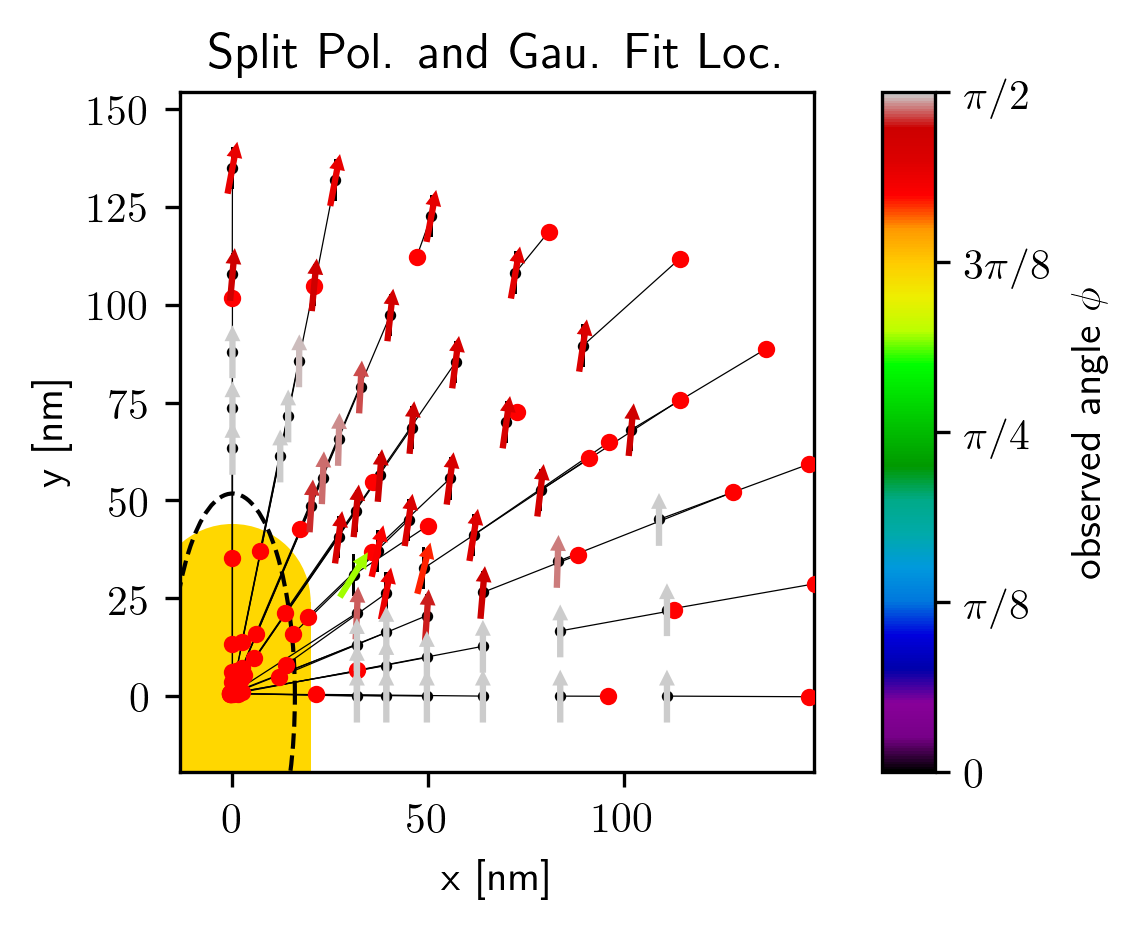

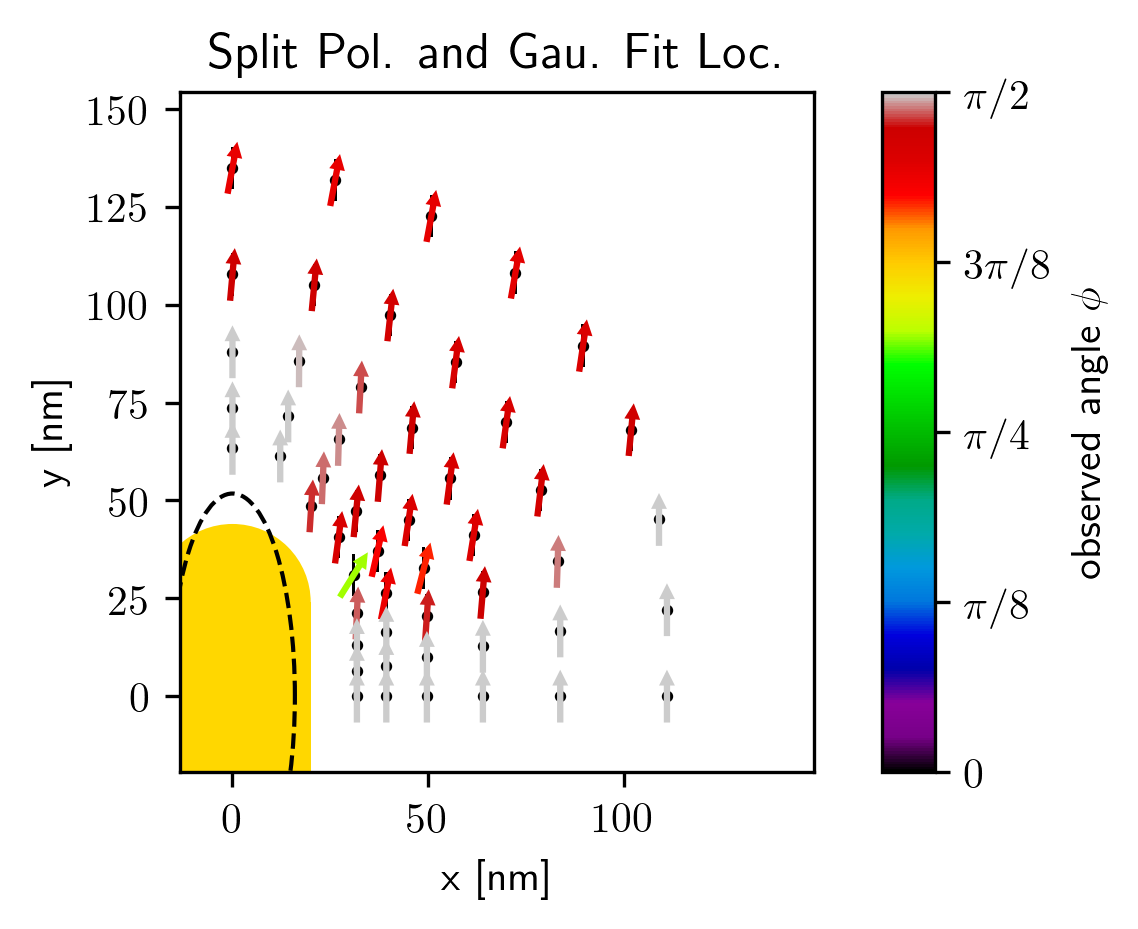

In [29]:
curly_sim_inst_y.trial_images = curly_sim_inst_y.BEM_images
curly_sim_inst_y.plot_mispol_map_wMisloc()
curly_sim_inst_y.plot_mispol_map()

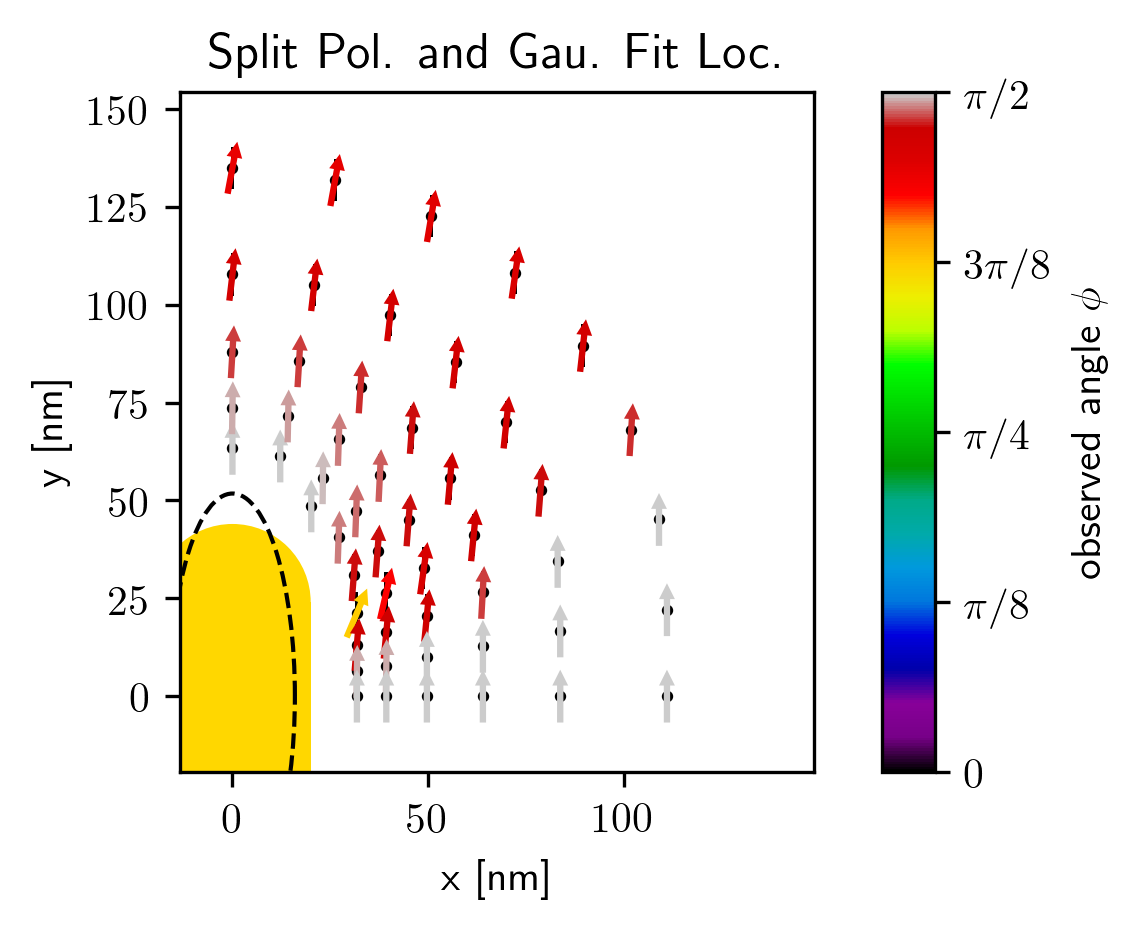

In [34]:
curly_mod_inst_y = fit.MolCoupNanoRodExp(curlys_dipole_locations, mol_angle=np.pi/2)
curly_mod_inst_y.plot_mispol_map()

In [30]:
curly_sim_inst_x = SimulatedExperiment(curlys_dipole_locations, mol_angle=0)
curly_sim_inst_x.calculate_BEM_fields()

1th molecule
calculating diffracted fields
2th molecule
calculating diffracted fields
3th molecule
calculating diffracted fields
4th molecule
calculating diffracted fields
5th molecule
calculating diffracted fields
6th molecule
calculating diffracted fields
7th molecule
calculating diffracted fields
8th molecule
calculating diffracted fields
9th molecule
calculating diffracted fields
10th molecule
calculating diffracted fields
11th molecule
calculating diffracted fields
12th molecule
calculating diffracted fields
13th molecule
calculating diffracted fields
14th molecule
calculating diffracted fields
15th molecule
calculating diffracted fields
16th molecule
calculating diffracted fields
17th molecule
calculating diffracted fields
18th molecule
calculating diffracted fields
19th molecule
calculating diffracted fields
20th molecule
calculating diffracted fields
21th molecule
calculating diffracted fields
22th molecule
calculating diffracted fields
23th molecule
calculating diffracted fiel

array([[5.85437707e-14, 7.10466073e-14, 8.05324325e-14, ...,
        8.25531350e-14, 7.24307297e-14, 5.93014704e-14],
       [8.27707386e-14, 1.00546556e-13, 1.14068922e-13, ...,
        1.17577977e-13, 1.03152739e-13, 8.44609904e-14],
       [7.56208282e-14, 9.19616542e-14, 1.04440880e-13, ...,
        1.08676938e-13, 9.54349075e-14, 7.82643859e-14],
       ...,
       [4.25257588e-16, 3.35738642e-16, 3.27481059e-16, ...,
        7.94948891e-16, 1.11251386e-15, 1.48321735e-15],
       [1.40443844e-16, 1.30099522e-16, 2.09905893e-16, ...,
        9.98704007e-16, 1.42300191e-15, 1.84370537e-15],
       [7.90118861e-17, 1.78102951e-16, 3.56741017e-16, ...,
        1.44622383e-15, 1.89395460e-15, 2.26720349e-15]])

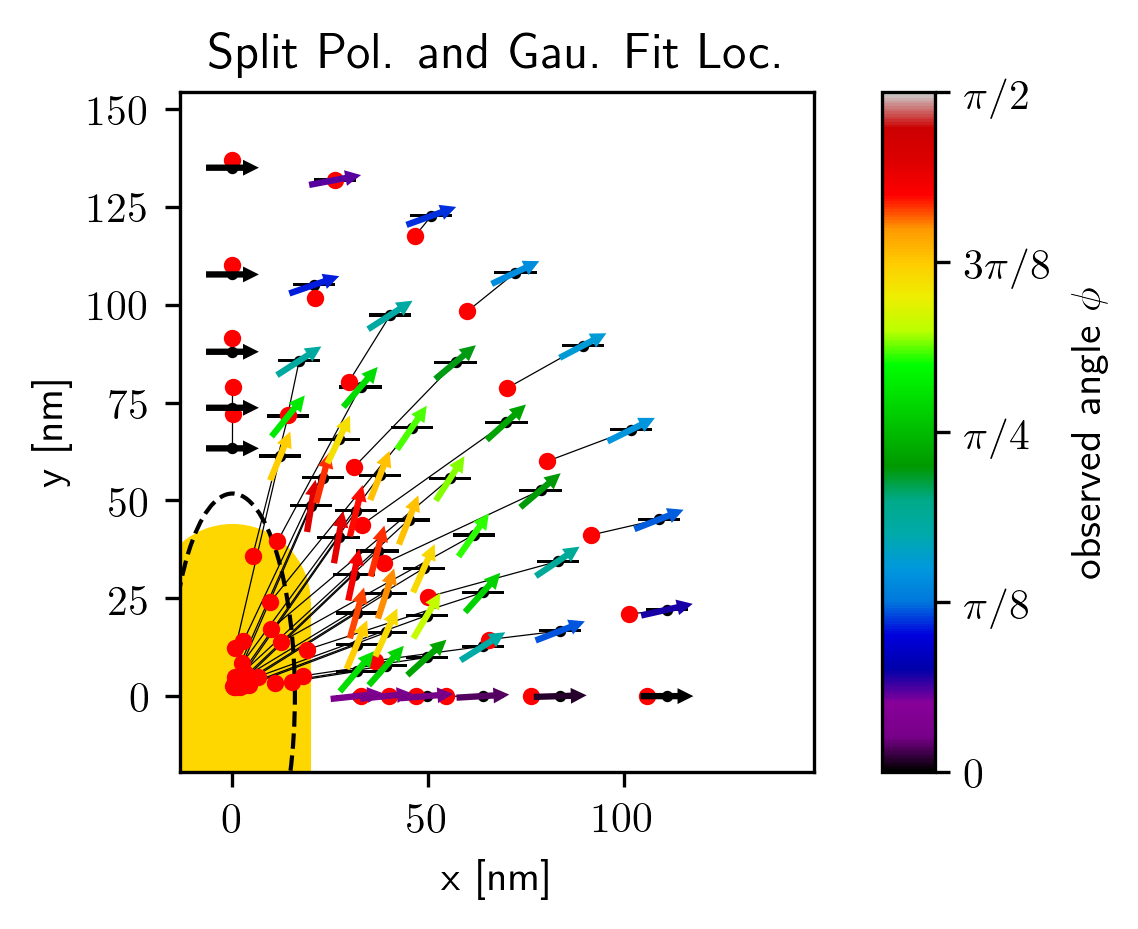

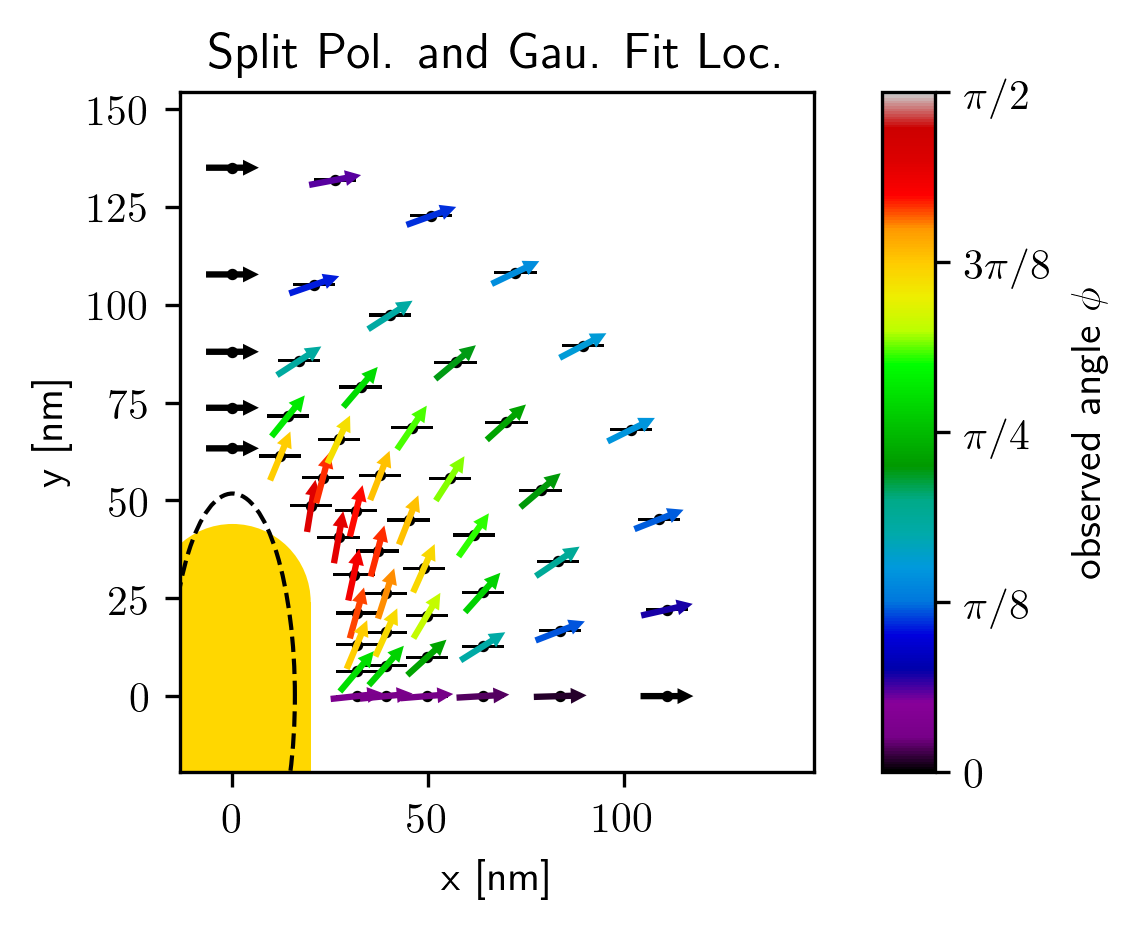

In [31]:
curly_sim_inst_x.trial_images = curly_sim_inst_x.BEM_images
curly_sim_inst_x.plot_mispol_map_wMisloc()
curly_sim_inst_x.plot_mispol_map()

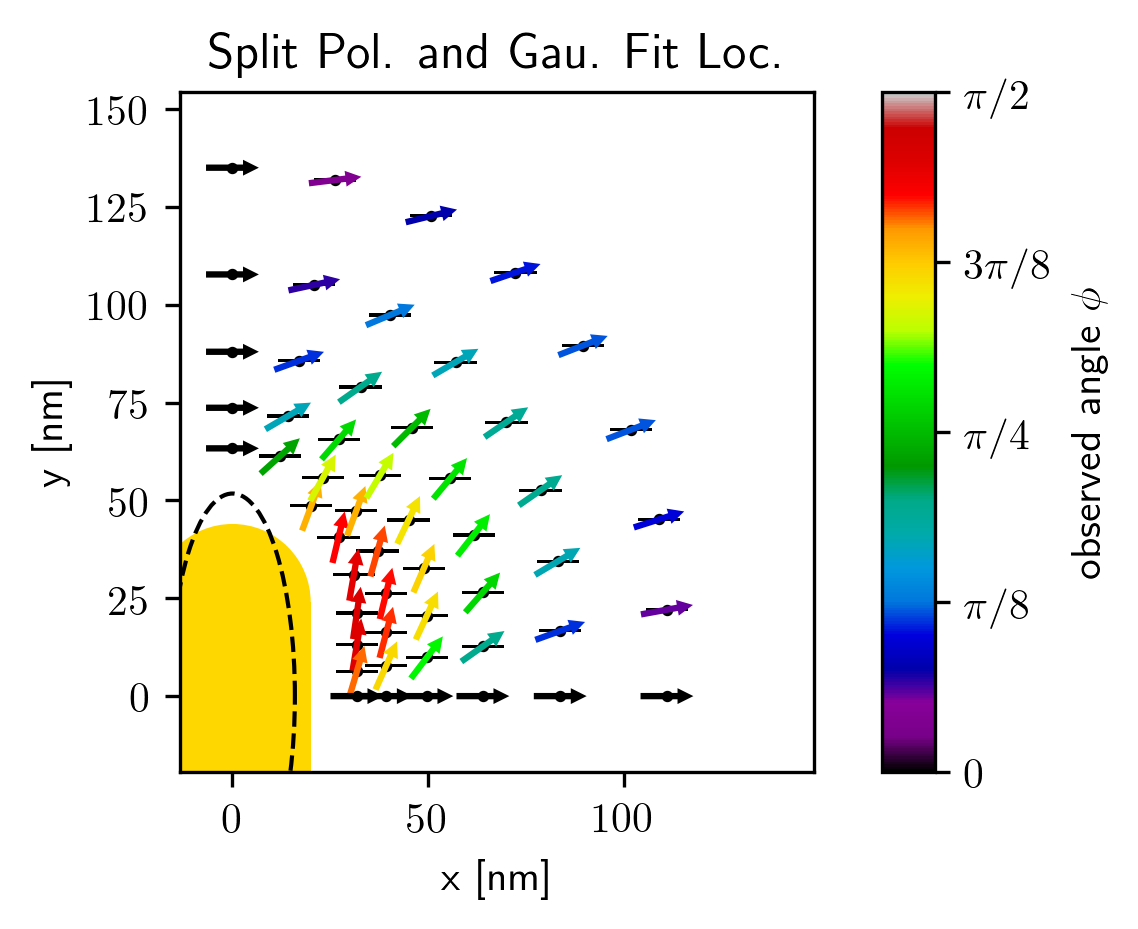

In [35]:
curly_mod_inst_x = fit.MolCoupNanoRodExp(curlys_dipole_locations, mol_angle=0)
curly_mod_inst_x.plot_mispol_map()

## Grids at Curly scale (150 nm squared) 

In [36]:
grid_locations_to_to150nm, angles = fixed_ori_mol_placement(mol_grid_pts_1D=7, x_max=150, y_max=150)
grid_sim_inst_y_mol_to150nm = SimulatedExperiment(grid_locations_to_to150nm, mol_angle=np.pi/2)
grid_sim_inst_y_mol_to150nm.calculate_BEM_fields()

1th molecule
calculating diffracted fields
2th molecule
calculating diffracted fields
3th molecule
calculating diffracted fields
4th molecule
calculating diffracted fields
5th molecule
calculating diffracted fields
6th molecule
calculating diffracted fields
7th molecule
calculating diffracted fields
8th molecule
calculating diffracted fields
9th molecule
calculating diffracted fields
10th molecule
calculating diffracted fields
11th molecule
calculating diffracted fields
12th molecule
calculating diffracted fields
13th molecule
calculating diffracted fields
14th molecule
calculating diffracted fields
15th molecule
calculating diffracted fields
16th molecule
calculating diffracted fields
17th molecule
calculating diffracted fields
18th molecule
calculating diffracted fields
19th molecule
calculating diffracted fields
20th molecule
calculating diffracted fields
21th molecule
calculating diffracted fields
22th molecule
calculating diffracted fields
23th molecule
calculating diffracted fiel

AttributeError: 'SimulatedExperiment' object has no attribute 'trial_images'

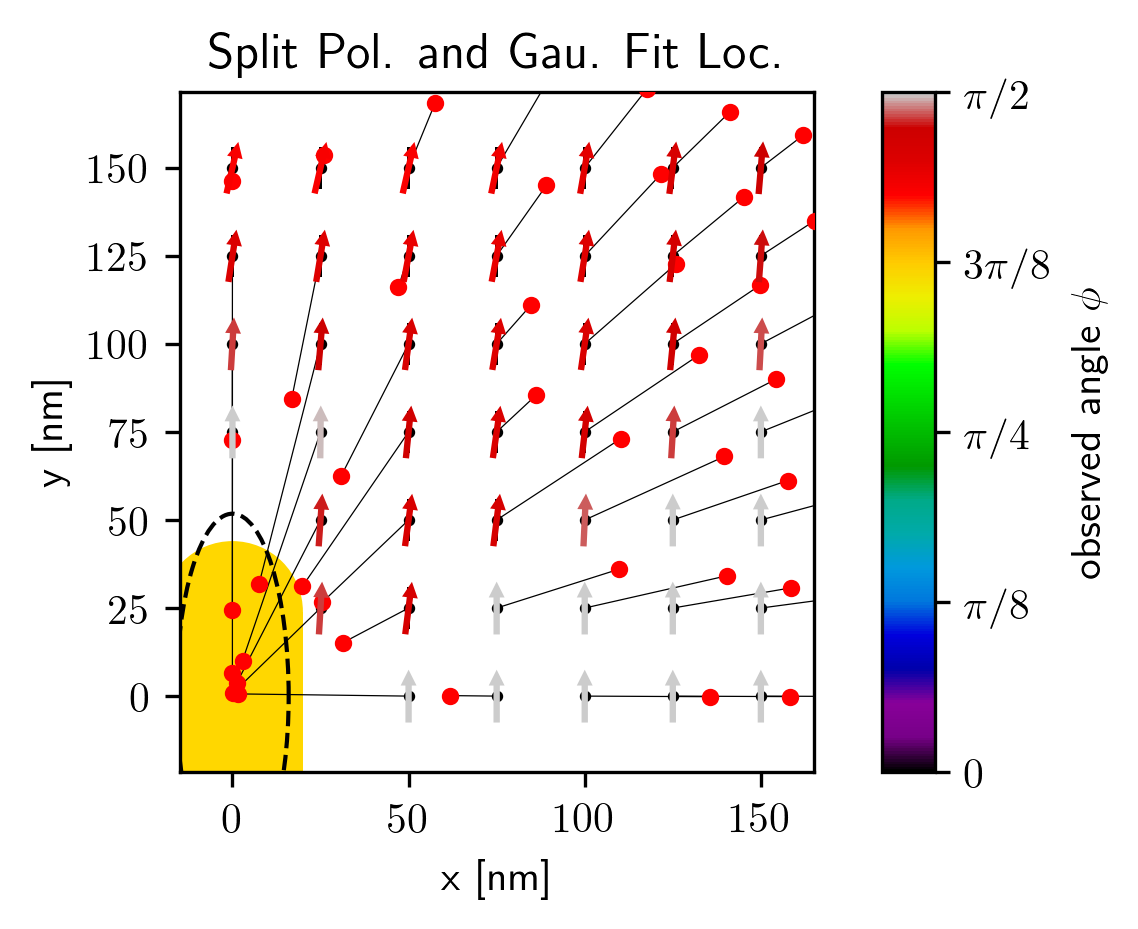

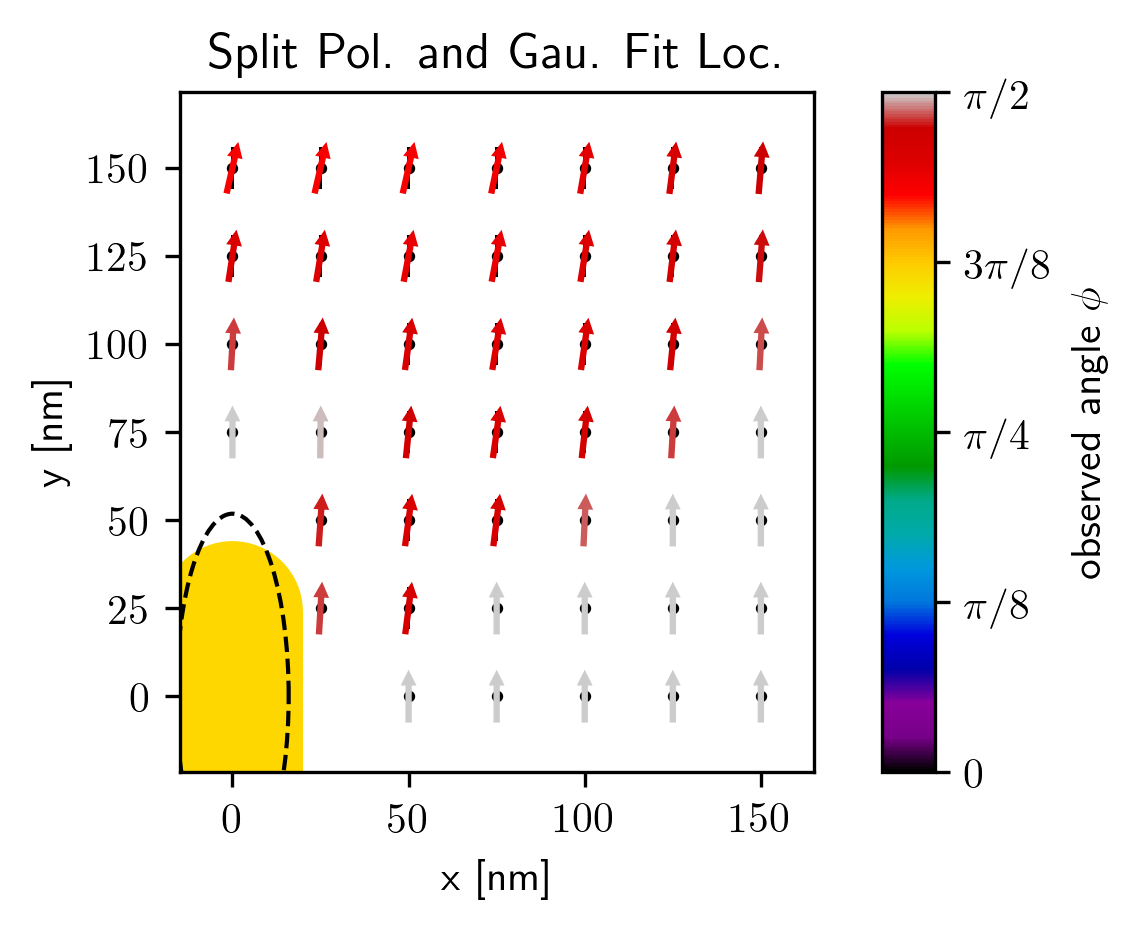

In [37]:
grid_sim_inst_y_mol_to150nm.trial_images = grid_sim_inst_y_mol_to150nm.BEM_images
grid_sim_inst_y_mol_to150nm.plot_mispol_map_wMisloc()
grid_sim_inst_y_mol_to150nm.plot_mispol_map()

1th molecule
calculating diffracted fields
2th molecule
calculating diffracted fields
3th molecule
calculating diffracted fields
4th molecule
calculating diffracted fields
5th molecule
calculating diffracted fields
6th molecule
calculating diffracted fields
7th molecule
calculating diffracted fields
8th molecule
calculating diffracted fields
9th molecule
calculating diffracted fields
10th molecule
calculating diffracted fields
11th molecule
calculating diffracted fields
12th molecule
calculating diffracted fields
13th molecule
calculating diffracted fields
14th molecule
calculating diffracted fields
15th molecule
calculating diffracted fields
16th molecule
calculating diffracted fields
17th molecule
calculating diffracted fields
18th molecule
calculating diffracted fields
19th molecule
calculating diffracted fields
20th molecule
calculating diffracted fields
21th molecule
calculating diffracted fields
22th molecule
calculating diffracted fields
23th molecule
calculating diffracted fiel

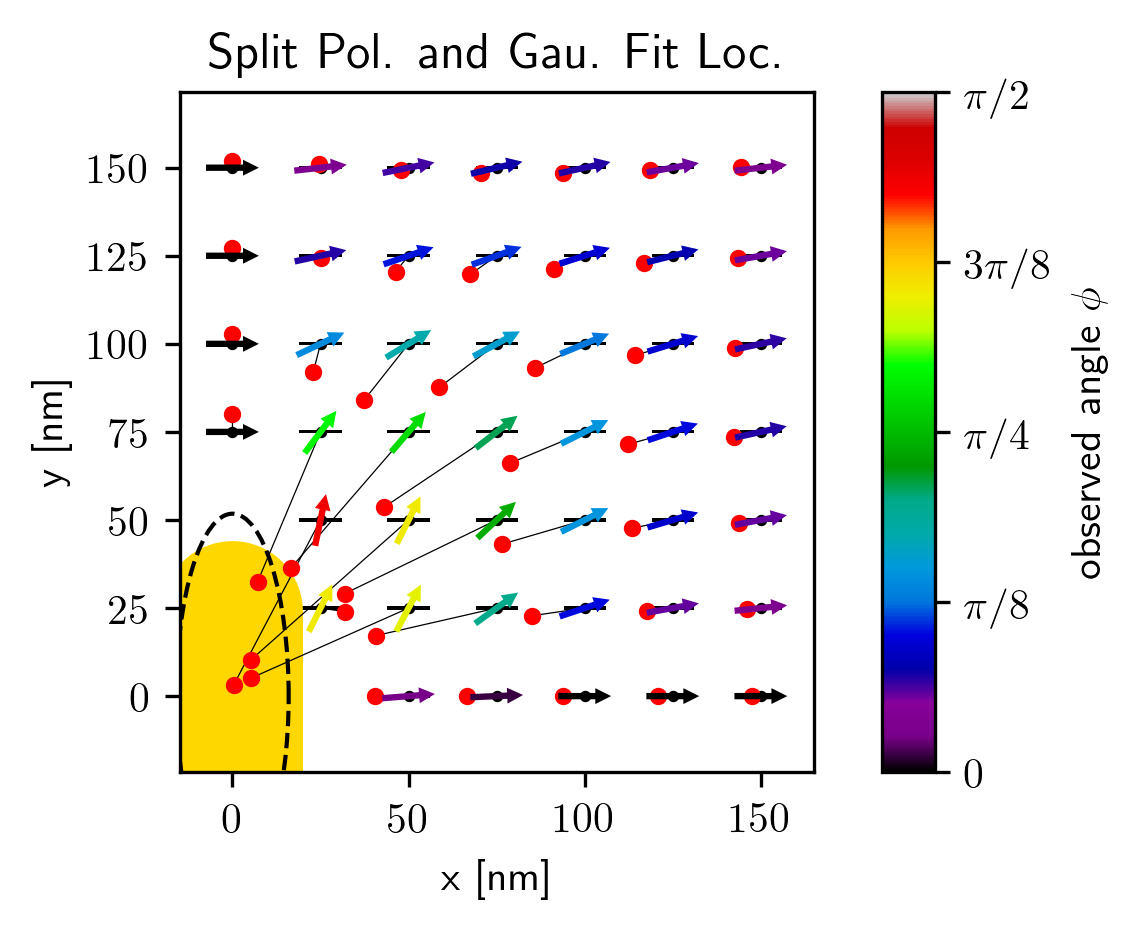

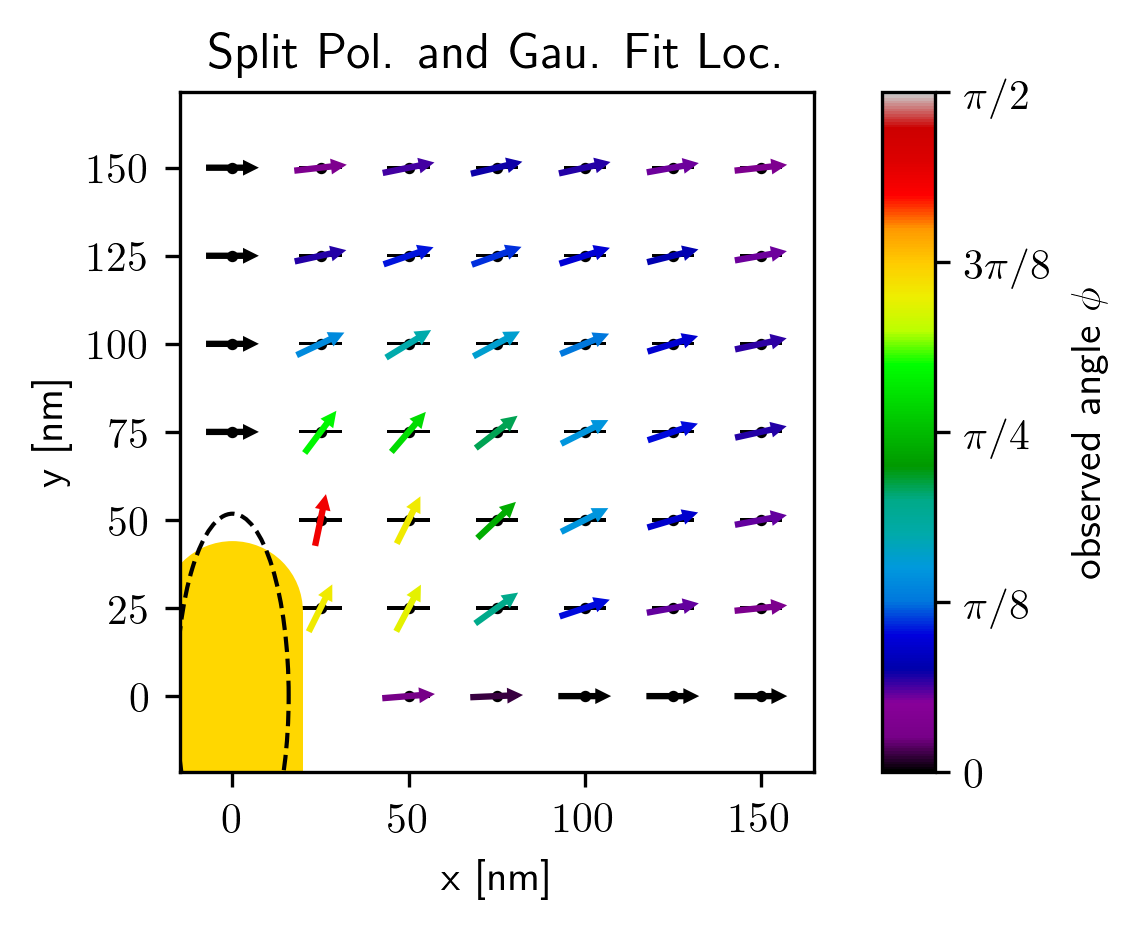

In [38]:
grid_locations_to_to150nm, angles = fixed_ori_mol_placement(mol_grid_pts_1D=7, x_max=150, y_max=150)
grid_sim_inst_x_mol_to150nm = SimulatedExperiment(grid_locations_to_to150nm, mol_angle=0)
grid_sim_inst_x_mol_to150nm.calculate_BEM_fields()

grid_sim_inst_x_mol_to150nm.trial_images = grid_sim_inst_x_mol_to150nm.BEM_images
grid_sim_inst_x_mol_to150nm.plot_mispol_map_wMisloc()
grid_sim_inst_x_mol_to150nm.plot_mispol_map()

In [9]:
locations, angles = fixed_ori_mol_placement(mol_grid_pts_1D=5, x_max=300, y_max=300)
simTestInst_few_mol = SimulatedExperiment(locations, mol_angle=np.pi/2)
simTestInst_few_mol.trial_images = simTestInst_few_mol.calculate_BEM_fields()

1th molecule
calculating diffracted fields
2th molecule
calculating diffracted fields
3th molecule
calculating diffracted fields
4th molecule
calculating diffracted fields
5th molecule
calculating diffracted fields
6th molecule
calculating diffracted fields
7th molecule
calculating diffracted fields
8th molecule
calculating diffracted fields
9th molecule
calculating diffracted fields
10th molecule
calculating diffracted fields
11th molecule
calculating diffracted fields
12th molecule
calculating diffracted fields
13th molecule
calculating diffracted fields
14th molecule
calculating diffracted fields
15th molecule
calculating diffracted fields
16th molecule
calculating diffracted fields
17th molecule
calculating diffracted fields
18th molecule
calculating diffracted fields
19th molecule
calculating diffracted fields
20th molecule
calculating diffracted fields
21th molecule
calculating diffracted fields
22th molecule
calculating diffracted fields
23th molecule
calculating diffracted fiel

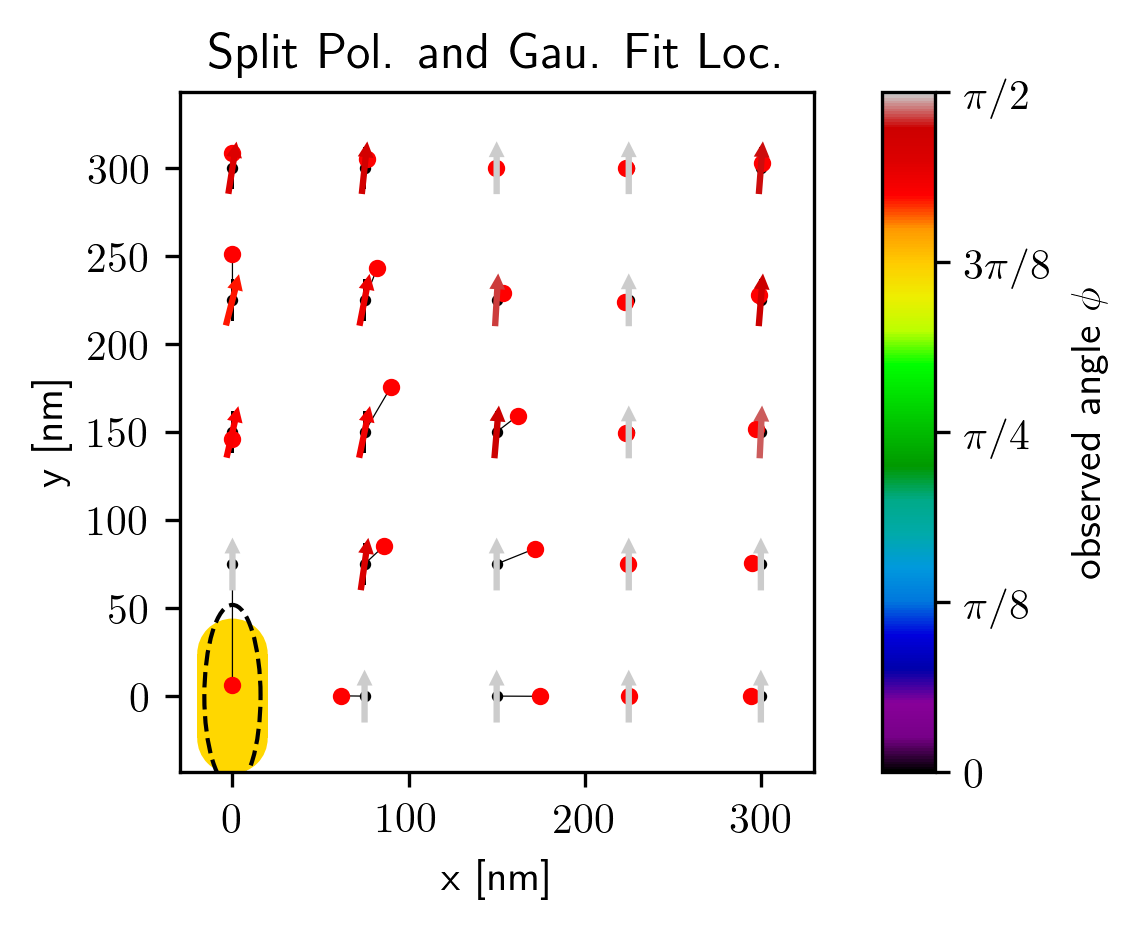

In [10]:
simTestInst_few_mol.plot_mispol_map_wMisloc()

#### drude results for comparison

In [ ]:
simTestInst_few_mol.plot_mispol_map_wMisloc()

### model fit

In [14]:
## Fit naively without knowing true location. 
test_BEM_fit_instance_few_mol = fit.FitModelToData(
    simTestInst_few_mol.BEM_images, 
    ini_guess=simTestInst_few_mol.mol_locations
    )
test_BEM_fit_few_mol = test_BEM_fit_instance_few_mol.fit_model_to_image_data()


initial guess for molecule 0 location: (0.0,75.0)
initial guess for molecule 1 location: (0.0,150.0)
initial guess for molecule 2 location: (0.0,225.0)
initial guess for molecule 3 location: (0.0,300.0)
initial guess for molecule 4 location: (75.0,0.0)
initial guess for molecule 5 location: (75.0,75.0)
initial guess for molecule 6 location: (75.0,150.0)
initial guess for molecule 7 location: (75.0,225.0)
initial guess for molecule 8 location: (75.0,300.0)
initial guess for molecule 9 location: (150.0,0.0)
initial guess for molecule 10 location: (150.0,75.0)
initial guess for molecule 11 location: (150.0,150.0)
initial guess for molecule 12 location: (150.0,225.0)
initial guess for molecule 13 location: (150.0,300.0)
initial guess for molecule 14 location: (225.0,0.0)
initial guess for molecule 15 location: (225.0,75.0)
initial guess for molecule 16 location: (225.0,150.0)
initial guess for molecule 17 location: (225.0,225.0)
initial guess for molecule 18 location: (225.0,300.0)
initial

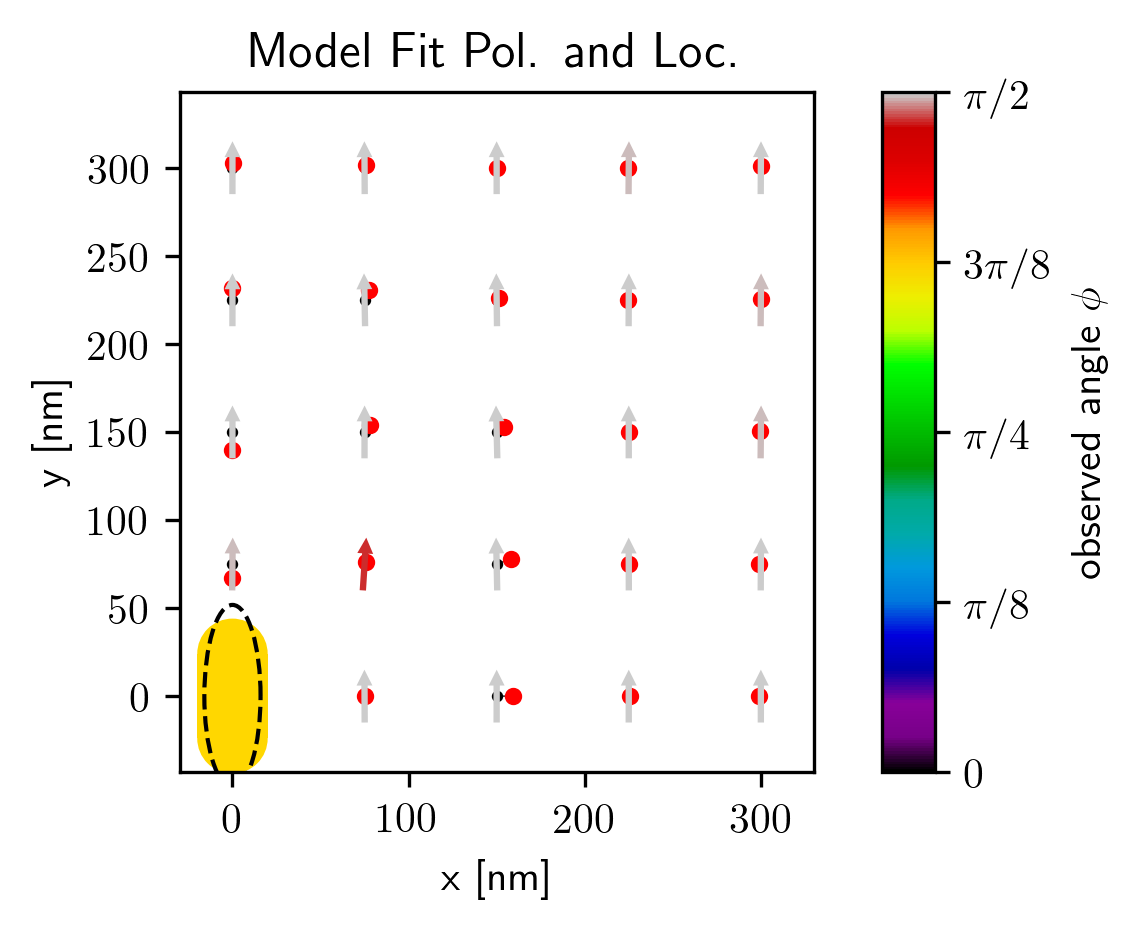

In [15]:
test_BEM_fit_instance_few_mol.plot_fit_results_as_quiver_map(simTestInst_few_mol)   

#### drude results for comparison